--- 
# Sandbox (Ambroise)
Tests for each part of this project

---

### Imports

In [80]:
%load_ext autoreload
%autoreload 2

#external libraries
import polars as pl
import pandas as pd
from datetime import date
import nest_asyncio
import os
import yfinance as yf
import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import asyncio

#internal libraries
from prompts import process_in_batches, import_data, preprocess_responses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing data test

## Prompting test

### Basic sentences
Adapted from the mistral website

In [ ]:
responses = preprocess_responses()

In [ ]:
# responses.write_csv("scores.csv")

In [ ]:
# testing on half of the dataset first
titles = import_data()
titles = titles.filter(pl.col('date').lt(date(2024,1,1)))

In [ ]:
nest_asyncio.apply()
prompts = titles.select('prompts').to_series().to_list()
csv_path = "responses_2024_2025.csv"
first_write = not os.path.exists(csv_path)

async for batch in process_in_batches(prompts, batch_size=100, concurrency=5):
    batch_df = pl.DataFrame({
        "index": [r[0] for r in batch],
        "prompt": [r[1] for r in batch],
        "response": [r[2] for r in batch],
    })

    csv_string = batch_df.write_csv(separator=",", include_header=first_write)
    with open(csv_path, "a", encoding="utf-8") as f:
        f.write(csv_string)

    first_write = False
    print(f"Wrote {len(batch)} rows to {csv_path}")


In [ ]:
pl.read_csv('responses_2024_2025.csv').select(pl.col('response').str.slice(0,10))

## Testing the model

In [47]:
scores = pl.read_csv('scores_2.csv')

In [63]:
scores.head()

date,increase,decrease,diff,score
date,i64,i64,i64,f64
2017-09-29,1,0,1,1.0
2017-11-12,1,0,1,1.0
2017-11-14,1,0,1,1.0
2017-11-20,1,0,1,1.0
2017-11-23,1,0,1,1.0


In [49]:
scores = pl.read_csv(
  "scores_2.csv",
  dtypes={"date": pl.Date}
)


/var/folders/zq/wrfz6jts6k73jk85nmz4ybrh0000gn/T/ipykernel_66388/2113586872.py:1: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  scores = pl.read_csv(


In [62]:
# drop when score is not NaN
scores = scores.filter(pl.col('score').is_not_nan())

In [64]:
min_date = scores["date"].min()
max_date = scores["date"].max()

start_str = min_date.strftime("%Y-%m-%d")
end_str   = (max_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")

df_pd = yf.download(
    tickers="BTC-USD",
    start=start_str,
    end=end_str,
    interval="1d",
    progress=False
)


if isinstance(df_pd.columns, pd.MultiIndex):
    df_pd.columns = df_pd.columns.get_level_values(0)

df_pd = df_pd.reset_index()
df_price = (
    pl.from_pandas(df_pd)
      .select([
         pl.col("Date").alias("date").cast(pl.Date),
         pl.col("Close").alias("close")
      ])
)

print(df_price.head())


shape: (5, 2)
┌────────────┬─────────────┐
│ date       ┆ close       │
│ ---        ┆ ---         │
│ date       ┆ f64         │
╞════════════╪═════════════╡
│ 2017-09-29 ┆ 4163.069824 │
│ 2017-09-30 ┆ 4338.709961 │
│ 2017-10-01 ┆ 4403.740234 │
│ 2017-10-02 ┆ 4409.319824 │
│ 2017-10-03 ┆ 4317.47998  │
└────────────┴─────────────┘


In [65]:
# for each date, if next date is higher : add 1, else 0
df_price = df_price.with_columns([
    (pl.col("close").shift(-1) > pl.col("close")).cast(pl.Int8).alias("actual")
])

In [66]:
df = scores.join(df_price.select(["date","actual"]), on="date", how="inner")

In [67]:
df = df.with_columns(
    (pl.col("score") > 0).cast(pl.Int8).alias("predicted")
)

In [68]:
print(df.head(50))

shape: (50, 7)
┌────────────┬──────────┬──────────┬──────┬───────┬────────┬───────────┐
│ date       ┆ increase ┆ decrease ┆ diff ┆ score ┆ actual ┆ predicted │
│ ---        ┆ ---      ┆ ---      ┆ ---  ┆ ---   ┆ ---    ┆ ---       │
│ date       ┆ i64      ┆ i64      ┆ i64  ┆ f64   ┆ i8     ┆ i8        │
╞════════════╪══════════╪══════════╪══════╪═══════╪════════╪═══════════╡
│ 2017-09-29 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 1      ┆ 1         │
│ 2017-11-12 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 1      ┆ 1         │
│ 2017-11-14 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 1      ┆ 1         │
│ 2017-11-20 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 0      ┆ 1         │
│ 2017-11-23 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 1      ┆ 1         │
│ …          ┆ …        ┆ …        ┆ …    ┆ …     ┆ …      ┆ …         │
│ 2018-06-15 ┆ 1        ┆ 0        ┆ 1    ┆ 1.0   ┆ 1      ┆ 1         │
│ 2018-06-22 ┆ 0        ┆ 1        ┆ -1   ┆ -1.0  ┆ 1      ┆ 0         │
│ 2018-06-26 ┆ 0        ┆ 1        ┆

In [69]:
df_clean = df.filter(
    pl.col("actual").is_not_null() &
    pl.col("predicted").is_not_null()
)

pdf = df_clean.select(["actual", "predicted"]).to_pandas()

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

acc  = accuracy_score(pdf.actual, pdf.predicted)
cm   = confusion_matrix(pdf.actual, pdf.predicted)
prec = precision_score(pdf.actual, pdf.predicted)
rec  = recall_score(pdf.actual, pdf.predicted)

print(f"Accuracy       : {acc:.3f}")
print(f"Confusion mat. :\n{cm}")
print(f"Precision      : {prec:.3f}")
print(f"Recall         : {rec:.3f}")


Accuracy       : 0.487
Confusion mat. :
[[161 601]
 [199 598]]
Precision      : 0.499
Recall         : 0.750


In [70]:
pdf

,actual,predicted
0,1,1
1,1,1
2,1,1
3,0,1
4,1,1
...,...,...
1554,0,1
1555,1,1
1556,0,1
1557,0,1


## New prompts with differents dates ranges.

In [ ]:
import os
import nest_asyncio
import polars as pl
from datetime import date

# --- Paramètres à ajuster pour chaque période ---
start_dt = date(2023, 1,  1)
end_dt   = date(2025, 1,  1)
csv_path = "responses_2023_2025.csv"
# -----------------------------------------------

# Charger tout et filtrer
titles = import_data().with_row_count("index")
subset = titles.filter(
    (pl.col("date") >= start_dt) &
    (pl.col("date") <  end_dt)
)
prompts = subset["prompts"].to_list()



In [20]:
from tqdm.asyncio import tqdm_asyncio

# Préparer le CSV
if os.path.exists(csv_path):
    os.remove(csv_path)
first_write = True

# Appliquer nest_asyncio
nest_asyncio.apply()

# Boucle asynchrone en batch with tqdm
async for batch in tqdm_asyncio(process_in_batches(prompts, batch_size=200, concurrency=5), desc="Processing batches"):
    batch_df = pl.DataFrame({
        "index":    [r[0] for r in batch],
        "prompt":   [r[1] for r in batch],
        "response": [r[2] for r in batch],
    })

    csv_str = batch_df.write_csv(separator=",", include_header=first_write)
    with open(csv_path, "a", encoding="utf-8") as f:
        f.write(csv_str)

    first_write = False
    print(f"--------Wrote {len(batch)} rows to {csv_path}--------")


Processing batches: 0it [00:00, ?it/s]

Processing prompts 0 to 199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] R

Processing batches: 1it [01:48, 108.23s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 200 to 399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, ret

Processing batches: 2it [03:27, 102.72s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 400 to 599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, ret

Processing batches: 3it [05:11, 103.71s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 600 to 799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, ret

Processing batches: 4it [07:01, 106.12s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 800 to 999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, ret

Processing batches: 5it [08:46, 105.70s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 1000 to 1199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 6it [10:33, 106.15s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 1200 to 1399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 7it [12:24, 107.49s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 1400 to 1599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 8it [14:00, 103.96s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 1600 to 1799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 9it [15:44, 103.91s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 1800 to 1999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 10it [17:31, 105.09s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 2000 to 2199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 11it [19:23, 107.01s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 2200 to 2399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 12it [21:15, 108.63s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 2400 to 2599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 13it [23:19, 113.19s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 2600 to 2799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 14it [25:21, 115.87s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 2800 to 2999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, r

Processing batches: 15it [26:56, 109.49s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 3000 to 3199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 16it [28:44, 109.06s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 3200 to 3399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 17it [30:35, 109.62s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 3400 to 3599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 18it [32:19, 108.09s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 3600 to 3799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 19it [34:07, 108.10s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 3800 to 3999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 20it [35:53, 107.44s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 4000 to 4199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, r

Processing batches: 21it [37:29, 103.90s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 4200 to 4399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 22it [39:13, 103.93s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 4400 to 4599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 23it [41:10, 107.77s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 4600 to 4799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 24it [43:01, 108.74s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 4800 to 4999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 25it [44:37, 104.97s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 5000 to 5199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 26it [46:29, 107.31s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 5200 to 5399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 27it [48:09, 105.02s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 5400 to 5599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 28it [49:53, 104.66s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 5600 to 5799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 29it [51:39, 105.06s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 5800 to 5999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 30it [53:26, 105.76s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 6000 to 6199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, r

Processing batches: 31it [55:17, 107.23s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 6200 to 6399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 32it [57:11, 109.23s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 6400 to 6599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 33it [1:01:08, 147.52s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 6600 to 6799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 34it [1:05:02, 173.47s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 6800 to 6999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 35it [1:08:26, 182.56s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 7000 to 7199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 36it [1:11:50, 189.04s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 7200 to 7399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 37it [1:15:03, 190.32s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 7400 to 7599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 38it [1:18:25, 193.77s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 7600 to 7799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, r

Processing batches: 39it [1:21:57, 199.30s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 7800 to 7999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 40it [1:25:28, 202.88s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 8000 to 8199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 41it [1:29:06, 207.48s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 8200 to 8399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 42it [1:33:38, 226.76s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 8400 to 8599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 43it [1:37:52, 234.79s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 8600 to 8799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 44it [1:42:13, 242.58s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 8800 to 8999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 45it [1:46:18, 243.50s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 9000 to 9199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 46it [1:50:15, 241.54s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 9200 to 9399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 47it [1:54:22, 243.23s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 9400 to 9599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 48it [1:58:10, 238.58s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 9600 to 9799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, r

Processing batches: 49it [2:02:40, 248.10s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 9800 to 9999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, r

Processing batches: 50it [2:06:33, 243.45s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 10000 to 10199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit,

Processing batches: 51it [2:10:19, 238.14s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 10200 to 10399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 52it [2:13:57, 232.33s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 10400 to 10599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 53it [2:18:03, 236.36s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 10600 to 10799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 54it [2:22:08, 239.00s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 10800 to 10999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit,

Processing batches: 55it [2:25:46, 232.51s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 11000 to 11199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 56it [2:29:28, 229.48s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 11200 to 11399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 57it [2:33:33, 234.23s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 11400 to 11599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 58it [2:37:23, 232.91s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 11600 to 11799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 59it [2:41:32, 237.55s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 11800 to 11999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 60it [2:45:47, 243.02s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 12000 to 12199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 61it [2:49:48, 242.26s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 12200 to 12399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit,

Processing batches: 62it [2:54:00, 245.19s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 12400 to 12599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 63it [2:57:30, 234.60s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 12600 to 12799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 64it [3:01:25, 234.73s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 12800 to 12999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 65it [3:05:20, 234.95s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 13000 to 13199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit,

Processing batches: 66it [3:09:36, 241.28s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 13200 to 13399...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit,

Processing batches: 67it [3:12:49, 226.65s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 13400 to 13599...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 68it [3:16:35, 226.52s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 13600 to 13799...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit,

Processing batches: 69it [3:20:52, 235.49s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 13800 to 13999...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit,

Processing batches: 70it [3:24:31, 230.79s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 14000 to 14199...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit,

Processing batches: 71it [3:28:34, 234.28s/it]

--------Wrote 200 rows to responses_2023_2025.csv--------
Processing prompts 14200 to 14354...
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 3/4 in 4.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 1/4 in 1.0s…
[429] Rate limit, retry 2/4 in 2.0s…
[429] Rate limit, retry 4/4 in 8.0s…
[429] Rate limit,

Processing batches: 72it [3:31:33, 176.30s/it]

--------Wrote 155 rows to responses_2023_2025.csv--------


## Aggregating the results and saving in a csv file

## score dataframe

In [ ]:
scores_2 = preprocess_responses(['responses_2017_2019.csv', 'responses_2019_2021.csv', 'responses_2021_2023.csv', 'responses_2023_2025.csv'])

## Plots of the scores dataframe 

In [82]:
scores_2

date,increase,decrease,diff,score
date,i32,i32,i32,f64
2017-09-29,1,0,1,1.0
2017-10-31,0,0,0,NaN
2017-11-12,1,0,1,1.0
2017-11-13,0,0,0,NaN
2017-11-14,1,0,1,1.0
…,…,…,…,…
2025-01-03,0,0,0,NaN
2025-01-04,0,0,0,NaN
2025-01-05,0,0,0,NaN


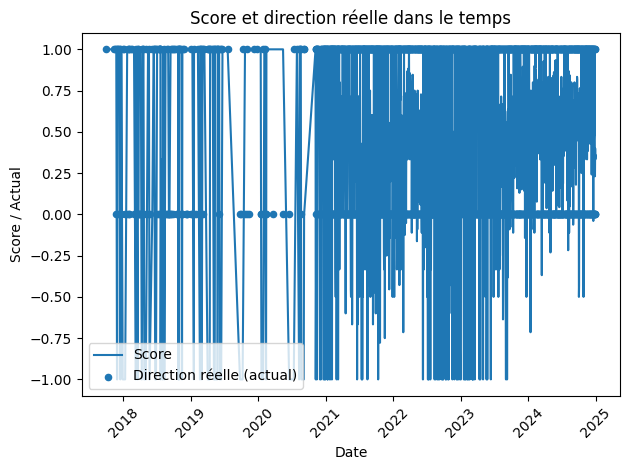

In [91]:
from plots import plot_score_time_series, plot_confusion_matrix_heatmap, plot_score_distribution, plot_correlation_heatmap, plot_score_vs_actual_scatter

plot_score_time_series(df)

Attention: 1 lignes avec NaN ont été supprimées.


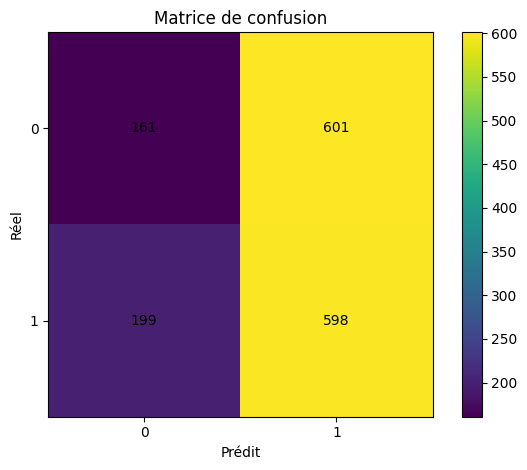

In [87]:
plot_confusion_matrix_heatmap(df)

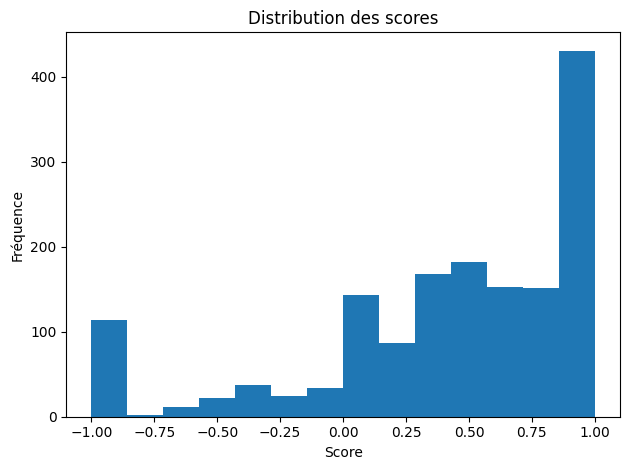

In [88]:
plot_score_distribution(df)

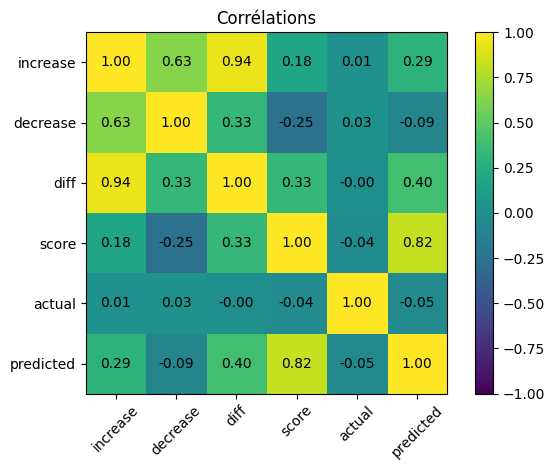

In [89]:
plot_correlation_heatmap(df)

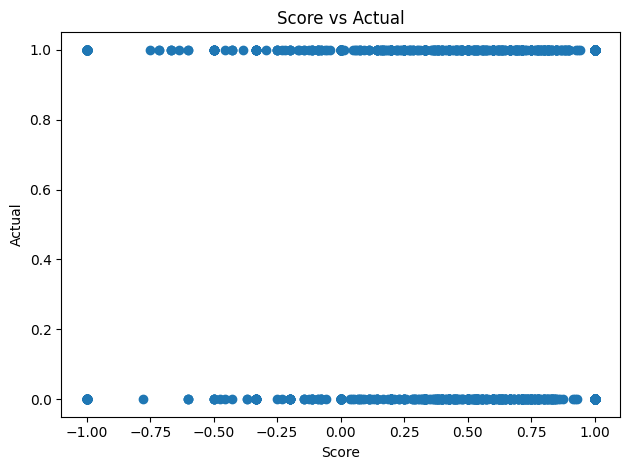

In [90]:
plot_score_vs_actual_scatter(df)